In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import pandas as pd
# set the working directory to the root of RCANE project
os.chdir('/Volumes/gech/cna/RCANE')
# set the threshold for loss/deletion and gain/amplification
low_threshold = -0.25
high_threshold = 0.2

Load the ground truth data and the predicted data

In [2]:
ground_truth = np.load('data/predict/TCGA_test.npz', allow_pickle=True)
prediction = np.load('data/predict/TCGA_test_pred.npz', allow_pickle=True)

Load the gene_wise gene names in each segment and the gene-wise SCNA file

In [3]:
gene_wise_cna = pd.read_csv('data/predict/TCGA_test_gene_cna.csv')
gene_wise_cna = gene_wise_cna.set_index('ID')
gene_names = np.loadtxt('data/gene_names_in_segments.csv', dtype=str, delimiter=',')

Match the sample IDs

In [4]:
ground_truth_ID = ground_truth['ID'].tolist()
prediction_ID = prediction['ID'].tolist()
ground_truth_cna = ground_truth['cna']
prediction_cna = prediction['cna']
ground_truth_cohort = ground_truth['cohort']
prediction_cohort = prediction['cohort']
# match the ID
ID_intersect = np.intersect1d(ground_truth_ID, prediction_ID)
ground_truth_idx = [ground_truth_ID.index(ID) for ID in ID_intersect]
prediction_idx = [prediction_ID.index(ID) for ID in ID_intersect]
ground_truth_cna = ground_truth_cna[ground_truth_idx]
prediction_cna = prediction_cna[prediction_idx]
ground_truth_cohort = ground_truth_cohort[ground_truth_idx]
prediction_cohort = prediction_cohort[prediction_idx]

Compute the SCNA status (-1 for loss/deletion, 0 for neutral, 1 for gain/amplification). Set NaN values to -2.

In [5]:
ground_truth_status = -2 * np.isnan(ground_truth_cna) + (ground_truth_cna > high_threshold) - (ground_truth_cna < low_threshold)
prediction_status = -2 * np.isnan(prediction_cna) + (prediction_cna > high_threshold) - (prediction_cna < low_threshold)

Plot the sample-wise Jaccard score

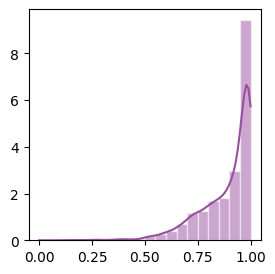

In [6]:
from sklearn.metrics import jaccard_score
from scipy.stats import gaussian_kde
sample_wise_jaccard = []
for i in range(ground_truth_status.shape[0]):
    sample_wise_jaccard.append(jaccard_score(ground_truth_status[i], prediction_status[i], average='micro', labels=[-1,0,1]))
sample_wise_jaccard = np.array(sample_wise_jaccard)
# plot the distribution of sample-wise Jaccard index
fig, ax = plt.subplots(figsize=(3,3))
plt.hist(sample_wise_jaccard, bins=20, density=True, alpha=0.5, color='#984f9f', edgecolor='white', linewidth=1,range=(0,1))
density = gaussian_kde(sample_wise_jaccard)
plt.plot(np.linspace(0, 1, 100), density(np.linspace(0, 1, 100)), color='#984f9f', linewidth=1.5)

Plot the segment-wise sensitivity, specificity and MCC

Text(0.5, 0, '')

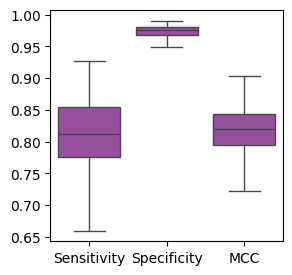

In [7]:
import pandas as pd
def sens_spec_MCC(y_true, y_pred):
    TP = np.sum((y_true == -1) & (y_pred == -1)) + np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true != -1) & (y_pred == -1)) + np.sum((y_true != 1) & (y_pred == 1))
    FN = np.sum((y_true !=0) & (y_pred == 0))
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    MCC = (TP * TN - FP * FN) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
    return sensitivity, specificity, MCC
sens, spec, mcc = [], [], []
for i in range(ground_truth_status.shape[1]):
    s, p, m = sens_spec_MCC(ground_truth_status[:,i], prediction_status[:,i])
    sens.append(s)
    spec.append(p)
    mcc.append(m)
df_sens = pd.DataFrame({'metric': 'sensitivity', 'value': sens})
df_spec = pd.DataFrame({'metric': 'specificity', 'value': spec})
df_mcc = pd.DataFrame({'metric': 'MCC', 'value': mcc})
df = pd.concat([df_sens, df_spec, df_mcc])
# plot the boxplot of segment-wise sensitivity, specificity, and MCC
fig, ax = plt.subplots(figsize=(3,3))
sns.boxplot(x='metric', y='value', data=df, color='#984f9f',showfliers=False, saturation=1)
ax.set_title('')
ax.set_ylabel('')
ax.set_xticks([0,1,2])
ax.set_xticklabels(['Sensitivity', 'Specificity','MCC'])
ax.set_xlabel('')

Plot the cohort-wise F1 score for loss/deletion, neutral and gain/amplification

Text(0.04, 0.5, '$F_1$ score')

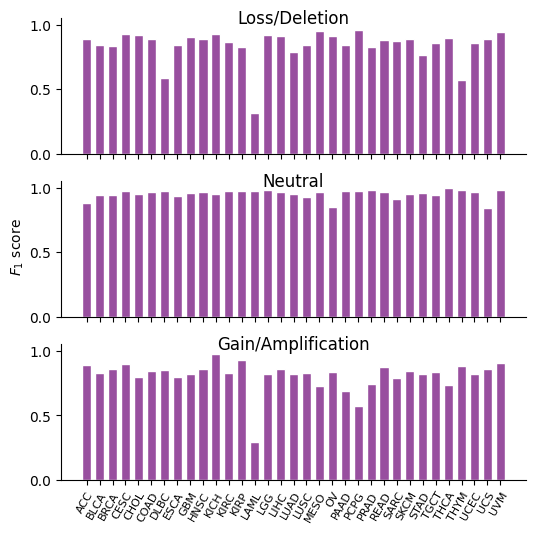

In [8]:
from sklearn.metrics import f1_score
def F1_score(y_true, y_pred):
    return f1_score(y_true.flatten(), y_pred.flatten(), average=None, labels=[-1,0,1])
COHORTS = np.unique(ground_truth_cohort)
F1_loss, F1_neutral, F1_gain = [], [], []
for i, cohort in enumerate(COHORTS):
    cohort_idx = np.where(ground_truth_cohort == cohort)[0]
    f1 = F1_score(ground_truth_status[cohort_idx], prediction_status[cohort_idx])
    F1_loss.append(f1[0])
    F1_neutral.append(f1[1])
    F1_gain.append(f1[2])
fig, axs = plt.subplots(3, 1, figsize=(6,6))
barwidth = 0.7
axs[0].bar(np.arange(len(COHORTS)), F1_loss, color='#984f9f', edgecolor='white', width=barwidth, label='Loss/Deletion')
axs[1].bar(np.arange(len(COHORTS)), F1_neutral, color='#984f9f', edgecolor='white', width=barwidth, label='Neutral')
axs[2].bar(np.arange(len(COHORTS)), F1_gain, color='#984f9f', edgecolor='white', width=barwidth, label='Gain/Amplification')
axs[0].set_title('Loss/Deletion', y=.9)
axs[1].set_title('Neutral', y=.9)
axs[2].set_title('Gain/Amplification', y=.9)
for ax in axs:
    ax.set_xticks(np.arange(len(COHORTS)))
    ax.set_xticklabels([])
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_ylim(0, 1.05)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
axs[2].set_xticklabels(COHORTS, rotation=60, ha='right', rotation_mode='anchor', fontsize=8)
fig.text(0.04, 0.5, r'$F_1$ score', va='center', rotation='vertical')

Match the IDs in the gene-wise file

In [9]:
ID_gene_wise_intersect = np.intersect1d(ID_intersect, gene_wise_cna.index)
gene_wise_cna = gene_wise_cna.reindex(index=ID_gene_wise_intersect)
gene_wise_pred_idx = [ID_intersect.tolist().index(ID) for ID in ID_gene_wise_intersect]
gene_wise_pred_cna = prediction_cna[gene_wise_pred_idx]
gene_wise_pred_cna = gene_wise_pred_cna.astype(float)
gene_wise_pred_status = -2 * np.isnan(gene_wise_pred_cna) + (gene_wise_pred_cna > high_threshold) - (gene_wise_pred_cna < low_threshold)
gene_wise_cna_status = -2 * np.isnan(gene_wise_cna) + (gene_wise_cna > high_threshold) - (gene_wise_cna < low_threshold)

Plot the TPR and FPR of selected tumor suppressor genes and oncogenes

Text(0, 0.5, 'True Positive Rate (%)')

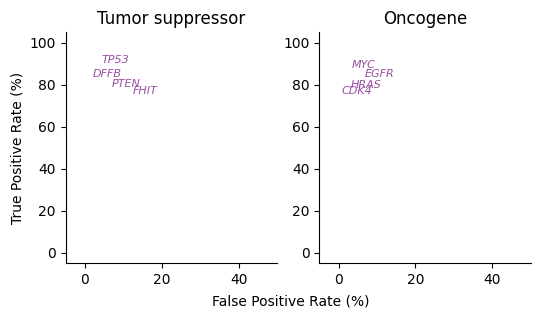

In [10]:
suppressor = ['TP53', 'DFFB', 'PTEN', 'FHIT']
oncogene = ['MYC', 'HRAS', 'EGFR', 'CDK4']
def TPR_FPR(y_true, y_pred):
    TP = np.sum((y_true == -1) & (y_pred == -1)) + np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true != -1) & (y_pred == -1)) + np.sum((y_true != 1) & (y_pred == 1))
    FN = np.sum((y_true !=0) & (y_pred == 0))
    TPR = TP / (TP + FN) * 100
    FPR = FP / (FP + TN) * 100
    return TPR, FPR
TPR_suppressor, FPR_suppressor, TPR_oncogene, FPR_oncogene = [], [], [], []

for gene in suppressor:
    idx = np.where(gene_names == gene)[0][0]
    tpr, fpr = TPR_FPR(gene_wise_cna_status[gene].values, gene_wise_pred_status[:,idx])
    TPR_suppressor.append(tpr)
    FPR_suppressor.append(fpr)
for gene in oncogene:
    idx = np.where(gene_names == gene)[0][0]
    tpr, fpr = TPR_FPR(gene_wise_cna_status[gene].values, gene_wise_pred_status[:,idx])
    TPR_oncogene.append(tpr)
    FPR_oncogene.append(fpr)

fig, axs = plt.subplots(1, 2, figsize=(6,3))
axs[0].set_title('Tumor suppressor')
axs[1].set_title('Oncogene')
for i, gene in enumerate(suppressor):
    axs[0].annotate(gene, (FPR_suppressor[i], TPR_suppressor[i]), color='#984f9f', fontsize=8, style='italic')
for i, gene in enumerate(oncogene):
    axs[1].annotate(gene, (FPR_oncogene[i], TPR_oncogene[i]), color='#984f9f', fontsize=8, style='italic')
for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim(-5, 50)
    ax.set_ylim(-5, 105)
fig.text(0.5, -.03, 'False Positive Rate (%)', ha='center')
axs[0].set_ylabel('True Positive Rate (%)')


Plot the whole-genome prediction of random samples

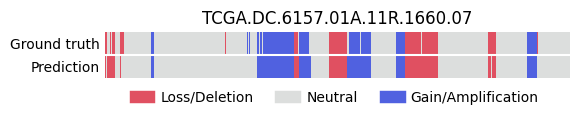

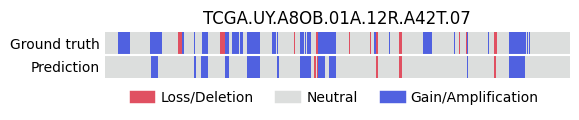

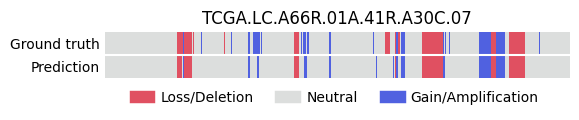

In [12]:
np.random.seed(0)
random_idx = np.random.choice(ground_truth_status.shape[0], 3, replace=False)
from matplotlib import colors
color = ['black', '#e05061', '#dcdedd', '#5061e0']
cmap = colors.ListedColormap(color)
bounds = [-2.5, -1.5, -0.5, 0.5, 1.5]
norm = colors.BoundaryNorm(bounds, cmap.N)
for i in random_idx:
    fig, axs = plt.subplots(1,1, figsize=(6,3))
    axs.imshow(np.vstack([ground_truth_status[i], prediction_status[i]]), cmap=cmap, aspect=75, norm=norm, interpolation='nearest')
    axs.axhline(y=0.5, color='white', linewidth=1.5)
    axs.spines['top'].set_visible(False)
    axs.spines['right'].set_visible(False)
    axs.spines['bottom'].set_visible(False)
    axs.spines['left'].set_visible(False)
    axs.set_yticks([0,1])
    axs.set_yticklabels(['Ground truth', 'Prediction'])
    axs.tick_params(axis='y', which='both', length=0)
    axs.set_xticks([])
    axs.set_title(f'{ID_intersect[i]}')
    axs.legend(handles=[plt.Line2D([0], [0], color=color[1], lw=8.95), plt.Line2D([0], [0], color=color[2], lw=8.95), plt.Line2D([0], [0], color=color[3], lw=8.95)], labels=['Loss/Deletion','Neutral','Gain/Amplification'], loc='upper center', bbox_to_anchor=(0.5, 0), ncol=4, frameon=False, handlelength=1)